True


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCR9D8Z/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCR9D8Z/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
**********************************************************************
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']

  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 31
  Class name (str form): donuts
  
tf.Tensor(
[[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]

 [[136  91  60]
  [137  92  61]
  [139  94  63]
  ...
  [137  53   7]
  [135  51   5]
  [131  47   1]]

 ...

 [[130  23   3]
  [134  31  14]
  [132 

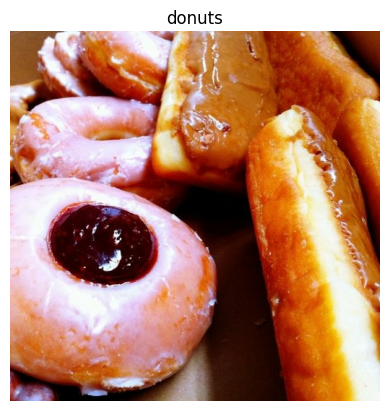

**********************************************************************
**********************************************************************
**********************************************************************
Image before preprocessing:
 [[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[1.34030609e+02 8.90306168e+01 5.80306129e+01]
  [1.36045914e+02 9.10459213e+01 6.00459175e+01]
  [1.37846939e+02 9.28469391e+01 6.38469391e+01]
  ...
  [1.30265366e+02 4.79183846e+01 1.62753057e+00]
  [1.30760223e+02 4.37602272e+01 4.59267795e-02]
  [1.34739838e+02 4.87398338e+01 1.73983324e+00]]

 [[1.41551025e+02 9.65510254e+01 6.55510254e+01]
  [1.49081650e+02 1.04081635e+02 7.30816345e+01]
  [1.51632660e+02 1.06632652e+02 7.56326523e+01]
  ...
  [1.30357101

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**********************************************************************
**********************************************************************


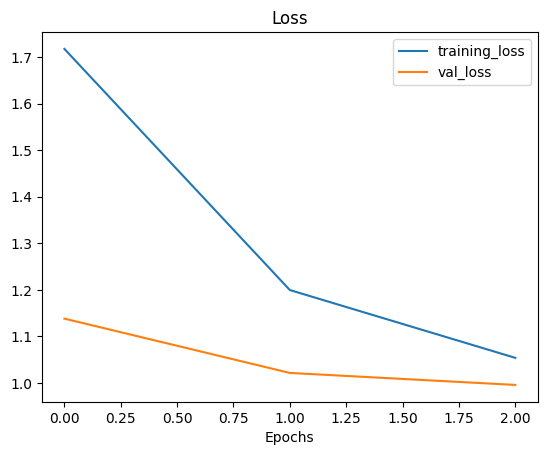

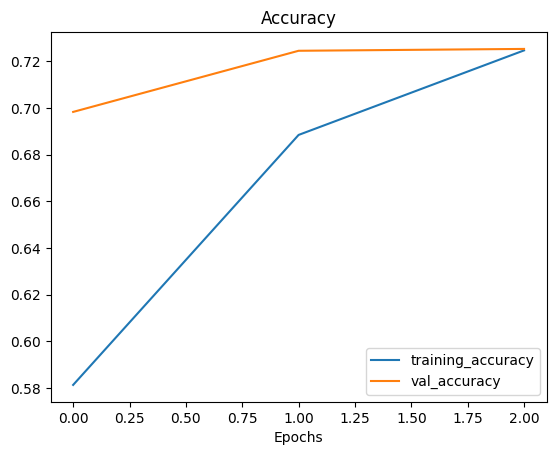

In [2]:

# Get TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow as tf

# List all available datasets
datasets_list = tfds.list_builders()  # get all available datasets in TFDS
print("food101" in datasets_list)  # is our target dataset in the list of TFDS datasets?

# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], # splits can be a little tricky, for more see: https://www.tensorflow.org/datasets/splits
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)
print("**********************************************************************")

print(ds_info.features)
# Get the class names
class_names = ds_info.features["label"].names
print(class_names[:10])

train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)

print(image)
print(tf.reduce_min(image), tf.reduce_max(image))

print("**********************************************************************")
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);
plt.show()
print("**********************************************************************")

# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes
    image to [img_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape])  # reshape target image
    # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
    return tf.cast(image, tf.float32), label  # return (float32_image, label) tuple

print("**********************************************************************")
print("**********************************************************************")

# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(
    f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")
print("**********************************************************************")
print("**********************************************************************")
#Batch and prepare datasets
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

print(train_data,test_data)
print("**********************************************************************")
#create modelling callbacks
# Create tensorboard callback (import from helper_functions.py)
from helper1 import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)  # don't print whether or not model is being saved

print("**********************************************************************")
#mixed precision - increase the speed
# Turn on mixed precision training
import tensorflow
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")  # set global data policy to mixed precision
print(mixed_precision.global_policy()
)

print("**********************************************************************")
#Build feature extraction model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

print("**********************************************************************")
model.summary()
print("**********************************************************************")
#fit the model
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
print("Evaluation:",results_feature_extract_model)
print("**********************************************************************")

model.save("food101_model.h5")
print("**********************************************************************")
from helper1 import plot_loss_curves
plot_loss_curves(history_101_food_classes_feature_extract)
print("**********************************************************************")
